In [34]:
import time
import copy
import numpy as np
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt

In [35]:
import yfinance as yf
yf.pdr_override()
data = yf.download('AAPL',start = '2020-01-01', end = '2022-11-01')
print(data.index.min(), data.index.max())
data.head()

[*********************100%***********************]  1 of 1 completed
2020-01-02 00:00:00 2022-10-31 00:00:00


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.561546,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.846367,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.426811,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,73.081482,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.257103,132079200


In [36]:
date_split = '2022-01-01'
train = data[:date_split]
test = data[date_split:]
len(train), len(test)

(505, 209)

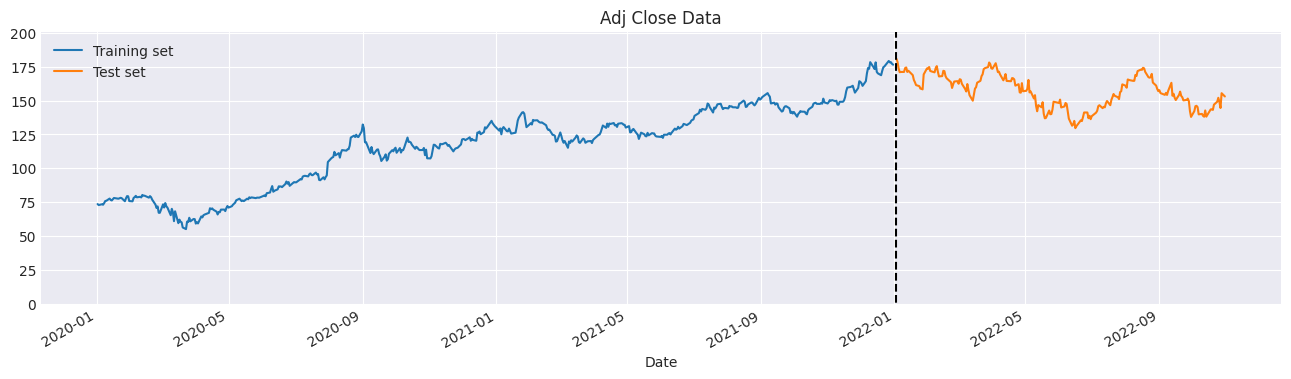

In [37]:
data['Adj Close'][:'2022-01-01'].plot(figsize=(16,4),legend=True)
data['Adj Close']['2022-01-01':].plot(figsize=(16,4),legend=True)
plt.vlines(data['2022-01-01':'2022-01-03'].index, -100, 1000, colors = "c", linestyles = "dashed",color = 'black')
plt.ylim((0,data['Adj Close'].max()+20))
plt.legend(['Training set','Test set'])
plt.title('Adj Close Data')
plt.show()

In [38]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 0
        self.positions = []
        self.position_value = 0
        self.history = [0 for _ in range(self.history_t)]
        self.maxshare = 0
        self.maxinv = 0
        self.tmpshare = 0
        self.tmpinv = 0
        self.proff = []
        return [self.position_value] + self.history
    
    def step(self, act):
        reward = 0
        if act == 1:
            self.positions.append(self.data.iloc[self.t, :]['Close'])
            self.tmpshare = self.tmpshare + 1
            self.tmpinv = self.tmpinv + self.data.iloc[self.t, :]['Close']
        elif act == 2: 
            if len(self.positions) == 0:
                reward = -1
            else:
                profits = 0
                for p in self.positions:
                    profits += (self.data.iloc[self.t, :]['Close'] - p)
                reward += profits
                self.profits += profits
                self.positions = []
                if self.tmpinv > self.maxinv:self.maxinv = self.tmpinv
                if self.tmpshare > self.maxshare:self.maxshare = self.tmpshare
                self.tmpinv = 0
                self.tmpshare = 0
                self.proff.append(profits)
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])

        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done

In [39]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    print(env.step(pact))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.7300033569335938], -1, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.7300033569335938, 0.592498779296875], 0, False)
([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [40]:
def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            obs, reward, done = env.step(pact)

            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards
    

In [100]:
Q, total_losses, total_rewards = train_dqn(Environment1(train))

/tmp/ipykernel_601/826053749.py:68: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shuffled_memory = np.random.permutation(memory)
/tmp/ipykernel_601/826053749.py:76: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)


5	0.0999999999999992	2520	-22.8	183736.551496242	20.77017617225647
10	0.0999999999999992	5040	-192.6	31298.31637568474	18.462637901306152
15	0.0999999999999992	7560	-187.4	2465.7542443811894	21.038654088974
20	0.0999999999999992	10080	-139.6	1127.5694447994233	21.186954498291016
25	0.0999999999999992	12600	-94.0	3249.263030910492	23.121211528778076
30	0.0999999999999992	15120	-87.2	9383.271466499567	23.22420907020569
35	0.0999999999999992	17640	-78.8	978.5585301369429	22.679073810577393
40	0.0999999999999992	20160	-48.0	409.81688457801937	21.8238205909729
45	0.0999999999999992	22680	-9.8	205.36124164946378	22.48490309715271
50	0.0999999999999992	25200	14.6	119.0489960839972	22.9324734210968


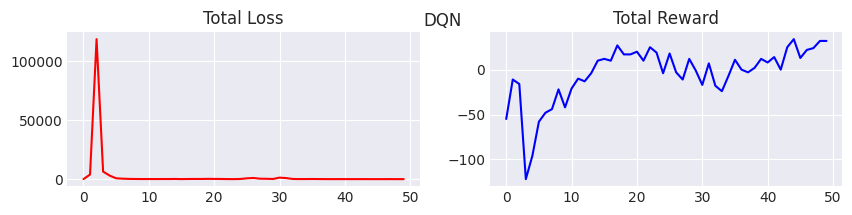

In [92]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(total_losses, color='red',label='Real')
plt.title('Total Loss')
plt.subplot(1, 2, 2)
plt.plot(total_rewards, color='blue',label='Predict')
plt.title('Total Reward')
plt.suptitle('DQN')
plt.show()
    

In [55]:
def plot_train_test_by_q(train_env, test_env, Q, algorithm_name):
    pobs = train_env.reset()
    train_acts = []
    train_rewards = []
    for _ in range(len(train_env.data)-1):
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        train_acts.append(pact)
            
        obs, reward, done = train_env.step(pact)
        train_rewards.append(reward)

        pobs = obs
        
    train_profits = train_env.profits

    pobs = test_env.reset()
    test_acts = []
    test_rewards = []

    for _ in range(len(test_env.data)-1):
    
        pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
        pact = np.argmax(pact.data)
        test_acts.append(pact)
            
        obs, reward, done = test_env.step(pact)
        test_rewards.append(reward)

        pobs = obs
        
    test_profits = test_env.profits
    max_invest = test_env.maxinv
    max_share = test_env.maxshare
    profitlist = test_env.proff
    profitlist = [round(num,2) for num in profitlist]
    print(profitlist)
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(12,5))
    plt.bar_label(plt.bar(range(len(profitlist)), profitlist), label_type='edge')
    plt.title('Profit obtained by selling, model: %s' %(algorithm_name))
    plt.ylabel('Price')
    plt.show()
    print(test_profits)
    train_copy = train_env.data.copy()
    test_copy = test_env.data.copy()
    train_copy['act'] = train_acts + [np.nan]
    train_copy['reward'] = train_rewards + [np.nan]
    test_copy['act'] = test_acts + [np.nan]
    test_copy['reward'] = test_rewards + [np.nan]
    train0 = train_copy[train_copy['act'] == 0]
    train1 = train_copy[train_copy['act'] == 1]
    train2 = train_copy[train_copy['act'] == 2]
    test0 = test_copy[test_copy['act'] == 0]
    test1 = test_copy[test_copy['act'] == 1]
    test2 = test_copy[test_copy['act'] == 2]
    plt_data = pd.concat([train_copy,test_copy])
    plt_buy = pd.concat([train1,test1])
    plt_sell = pd.concat([train2,test2])
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(12,5))
    plt.plot(plt_data.index,plt_data['Close'], color = 'gray', label='Close price')
    plt.scatter(plt_buy.index,plt_buy['Close'], marker = '^', color = 'crimson', label='Buy',zorder = 10)
    plt.scatter(plt_sell.index,plt_sell['Close'], marker = 'v', color = 'limegreen', label='Sell',zorder = 10)
    plt.vlines(data['2022-01-01':'2022-01-03'].index, -100, 1000, colors = "c", linestyles = "dashed",color = 'black')
    plt.ylim((0,plt_data['Close'].max()+20))
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.title('%s: Profit:%f; Max invest:%f; Max share:%f' %(algorithm_name, test_profits, max_invest, max_share))
    plt.legend()
    plt.show()
    

[24.94, 60.66, 9.13, 8.63, -16.05, -5.33, 1.09, 6.54, -47.41, -49.76, 4.31, -3.03, 9.14, 6.54, 5.16, -0.38, -11.55, -19.59, 13.53, -1.67, -5.75, 12.45, -3.83, 41.45]


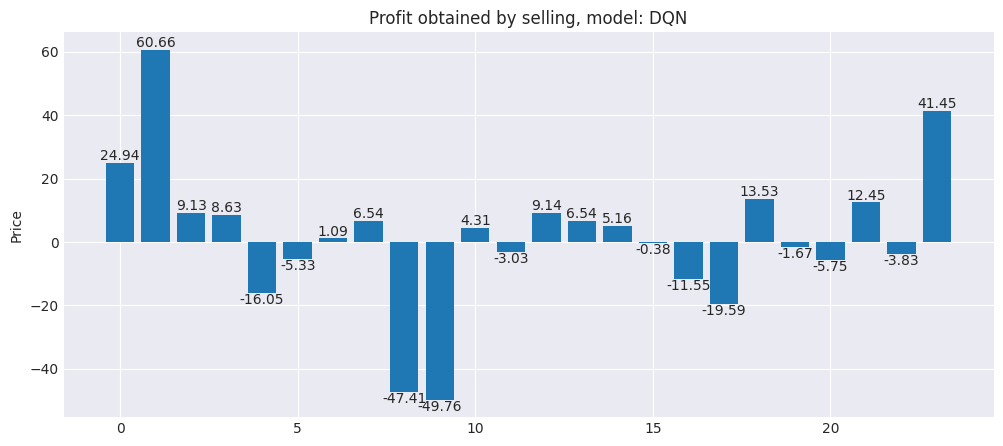

39.22004699707031


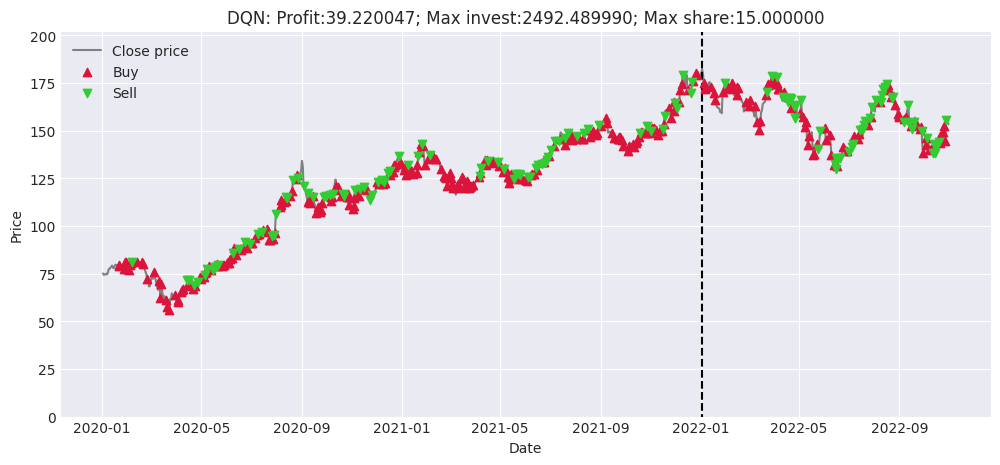

In [101]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'DQN')

In [57]:
# Double DQN

def train_ddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            obs, reward, done = env.step(pact)

            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])

                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [102]:
Q, total_losses, total_rewards = train_ddqn(Environment1(train))

/tmp/ipykernel_601/2788410712.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shuffled_memory = np.random.permutation(memory)
/tmp/ipykernel_601/2788410712.py:78: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)


5	0.0999999999999992	2520	-7.6	30.132123719528316	24.720165967941284
10	0.0999999999999992	5040	21.4	13.039995961077512	23.183204650878906
15	0.0999999999999992	7560	10.6	7.188135187700391	20.599783420562744
20	0.0999999999999992	10080	1.6	3.6412750001996756	19.99395179748535
25	0.0999999999999992	12600	9.8	4.139776493189856	21.903791904449463
30	0.0999999999999992	15120	32.0	6.2384629705920815	22.694126844406128
35	0.0999999999999992	17640	24.8	3.8872693470679223	20.679017305374146
40	0.0999999999999992	20160	29.2	4.634038525773212	21.103347539901733
45	0.0999999999999992	22680	30.4	6.941237305477261	21.3163480758667
50	0.0999999999999992	25200	16.8	3.4824007557705046	22.02583622932434


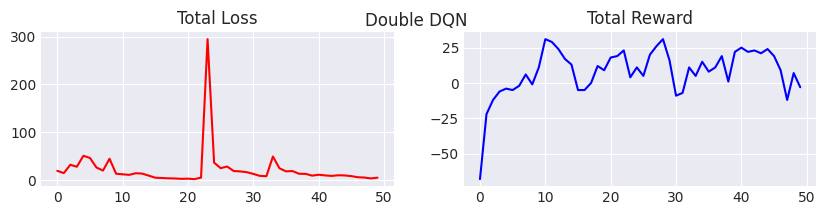

In [65]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(total_losses, color='red',label='Real')
plt.title('Total Loss')
plt.subplot(1, 2, 2)
plt.plot(total_rewards, color='blue',label='Predict')
plt.title('Total Reward')
plt.suptitle('Double DQN')
plt.show()

[16.43, 8.51, 12.85, 0.19, 11.55, 9.85, 31.76, 12.72, 3.89]


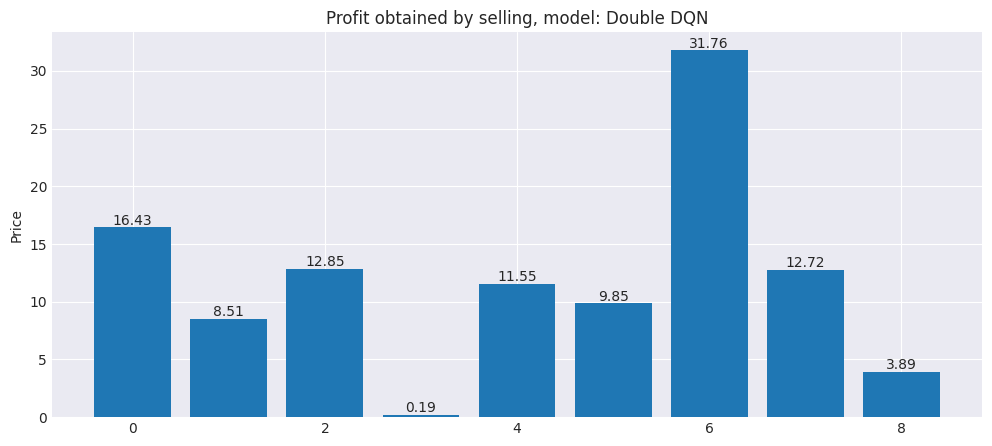

107.75003051757812


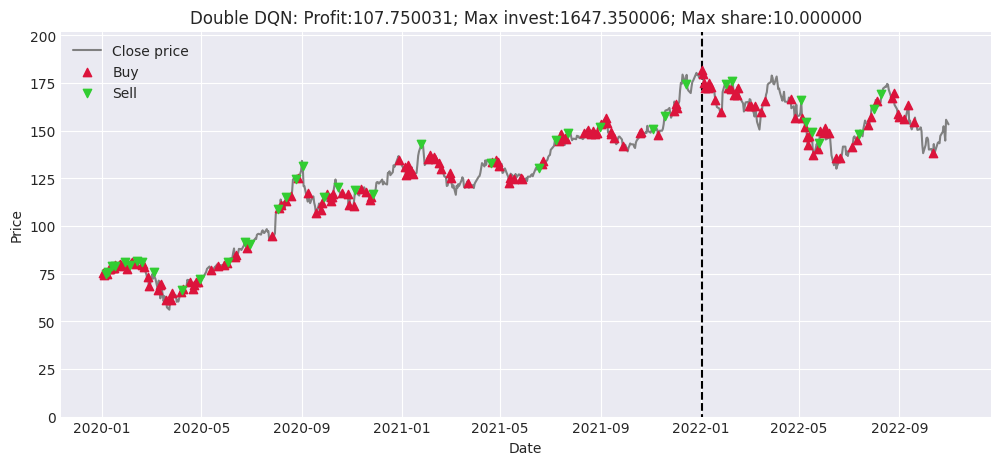

In [103]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'Double DQN')

In [84]:
# Dueling Double DQN

def train_dddqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, hidden_size//2),
                fc4 = L.Linear(hidden_size, hidden_size//2),
                state_value = L.Linear(hidden_size//2, 1),
                advantage_value = L.Linear(hidden_size//2, output_size)
            )
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            hs = F.relu(self.fc3(h))
            ha = F.relu(self.fc4(h))
            state_value = self.state_value(hs)
            advantage_value = self.advantage_value(ha)
            advantage_mean = (F.sum(advantage_value, axis=1)/float(self.output_size)).reshape(-1, 1)
            q_value = F.concat([state_value for _ in range(self.output_size)], axis=1) + (advantage_value - F.concat([advantage_mean for _ in range(self.output_size)], axis=1))
            return q_value

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 50
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 5

    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []

    start = time.time()
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0

        while not done and step < step_max:

            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

            obs, reward, done = env.step(pact)

            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool_)

                        q = Q(b_pobs)
                        indices = np.argmax(q.data, axis=1)
                        maxqs = Q_ast(b_obs).data
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxqs[j, indices[j]]*(not b_done[j])

                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            elapsed_time = time.time()-start
            print('\t'.join(map(str, [epoch+1, epsilon, total_step, log_reward, log_loss, elapsed_time])))
            start = time.time()
            
    return Q, total_losses, total_rewards

In [85]:
Q, total_losses, total_rewards = train_dddqn(Environment1(train))

/tmp/ipykernel_601/1081923673.py:81: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  shuffled_memory = np.random.permutation(memory)


5	0.0999999999999992	2520	-15.2	11.624589605256915	28.536494731903076
10	0.0999999999999992	5040	13.4	3.3642466558143496	34.96438121795654
15	0.0999999999999992	7560	17.4	4.811929859896191	35.622678995132446
20	0.0999999999999992	10080	24.6	2.8058333365479484	33.71659517288208
25	0.0999999999999992	12600	34.8	3.72099652281031	36.77264070510864
30	0.0999999999999992	15120	33.6	2.828527122805826	35.5660457611084
35	0.0999999999999992	17640	22.0	2.0308463320485317	51.29677963256836
40	0.0999999999999992	20160	19.4	1.2066764125484042	37.11772179603577
45	0.0999999999999992	22680	22.0	1.9449611634016037	38.544424057006836
50	0.0999999999999992	25200	36.0	5.617154068336822	39.02359056472778


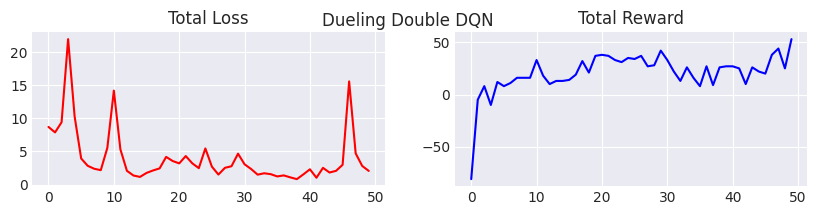

In [86]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,2))
plt.subplot(1, 2, 1)
plt.plot(total_losses, color='red',label='Real')
plt.title('Total Loss')
plt.subplot(1, 2, 2)
plt.plot(total_rewards, color='blue',label='Predict')
plt.title('Total Reward')
plt.suptitle('Dueling Double DQN')
plt.show()

[17.34, 7.54, 4.82, 10.01, 28.52, 6.22, 3.36, 52.85, 24.36, 7.59, 16.14, 16.08]


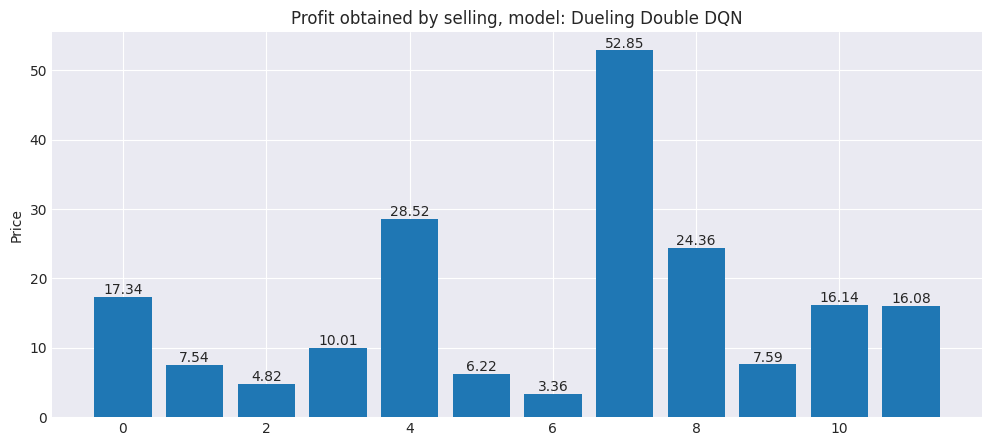

194.8299102783203


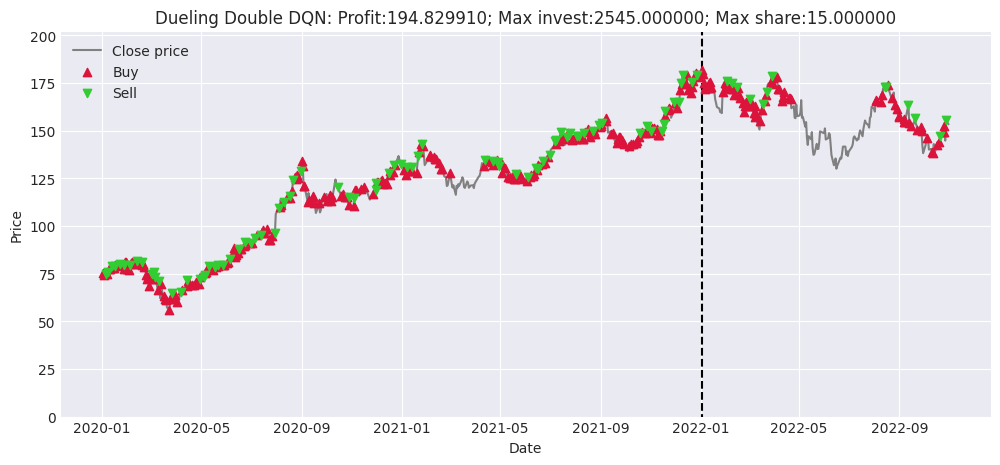

In [87]:
plot_train_test_by_q(Environment1(train), Environment1(test), Q, 'Dueling Double DQN')